In [1]:
# 1. Install Java Development Kit (JDK) 8
# Spark requires a Java environment to run
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# 2. Install Apache Spark
# We install version 3.5.1 (a recent, stable version)
!pip install pyspark==3.5.1

# 3. Install findspark (makes finding Spark easy)
!pip install findspark

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


# Install vaderSentiment for sentiment analysis

In [7]:
!pip install vaderSentiment
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 2.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 29.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 KB 23.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 38.8 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.0/325.0 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 89.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 60.4 MB/s eta 0:00:0000:01:00:01


In [13]:
!pip install pyarrow

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 19.8 MB/s eta 0:00:0000:0100:01


In [15]:
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable


# Download and retrieve data

In [3]:
import gzip
import shutil

# URL of the gzipped file
url = "https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/goodreads_reviews_spoiler.json.gz"
output_gz_file = "goodreads_reviews_spoiler.json.gz"
output_json_file = "goodreads_reviews_spoiler.json"

# Download the file using wget
!wget -O {output_gz_file} {url}

# Decompress the file
with gzip.open(output_gz_file, 'rb') as f_in:
    with open(output_json_file, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"Downloaded and decompressed {output_gz_file} to {output_json_file}")

--2026-01-13 17:08:33--  https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/goodreads_reviews_spoiler.json.gz
Resolving mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)... 169.228.63.88
Connecting to mcauleylab.ucsd.edu (mcauleylab.ucsd.edu)|169.228.63.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 620197603 (591M) [application/gzip]
Saving to: ‘goodreads_reviews_spoiler.json.gz’

goodreads_reviews_s 100%[===================>] 591.47M  15.9MB/s    in 38s     

2026-01-13 17:09:13 (15.4 MB/s) - ‘goodreads_reviews_spoiler.json.gz’ saved [620197603/620197603]

Downloaded and decompressed goodreads_reviews_spoiler.json.gz to goodreads_reviews_spoiler.json


# Trying to find a relations between books and their reviews

Uploading goodreads_books.json.gz to HDFS...
Uploading goodreads_reviews_spoiler.json.gz to HDFS...
Loading Books Metadata from HDFS...


Loading Reviews Data from HDFS...


Joining datasets on the cluster...
Generating Correlation Matrix...


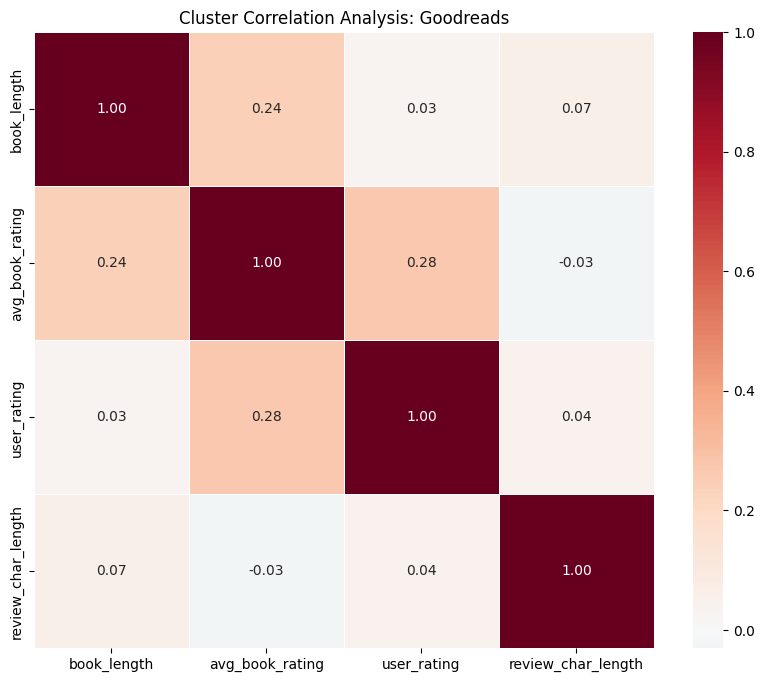

In [10]:
import os
import requests
import subprocess
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, concat_ws, flatten, expr
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. DOWNLOAD & UPLOAD TO HDFS ---
def manage_data_files(url, filename):
    # Step A: Download to local disk if not present
    if not os.path.exists(filename):
        print(f"Downloading {filename} to local disk...")
        r = requests.get(url, allow_redirects=True)
        with open(filename, 'wb') as f:
            f.write(r.content)
    
    # Step B: Upload from local disk to HDFS
    # This ensures every node in the cluster can access the file
    print(f"Uploading {filename} to HDFS...")
    # 'hdfs dfs -put -f' force uploads the file to the user's HDFS home directory
    subprocess.run(["hdfs", "dfs", "-put", "-f", filename, f"/user/ubuntu/{filename}"], check=True)

books_url = "https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/goodreads_books.json.gz"
reviews_url = "https://mcauleylab.ucsd.edu/public_datasets/gdrive/goodreads/goodreads_reviews_spoiler.json.gz"

# Run the download and HDFS upload
manage_data_files(books_url, "goodreads_books.json.gz")
manage_data_files(reviews_url, "goodreads_reviews_spoiler.json.gz")

# --- 2. INITIALIZE SPARK (CLUSTER MODE) ---
# Note: We removed .master("local[*]") so it uses the cluster manager defaults
spark = SparkSession.builder \
    .appName("GoodreadsClusterAnalysis") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

try:
    # --- 3. LOAD FROM HDFS ---
    # We remove "file://" and "os.path" because Spark defaults to HDFS in cluster mode
    print("Loading Books Metadata from HDFS...")
    books_df = spark.read.json("goodreads_books.json.gz")

    books_num = books_df.select(
        col("book_id"),
        expr("try_cast(num_pages as int)").alias("book_length"),
        expr("try_cast(average_rating as float)").alias("avg_book_rating")
    ).dropna()

    print("Loading Reviews Data from HDFS...")
    reviews_df = spark.read.json("goodreads_reviews_spoiler.json.gz")

    reviews_num = reviews_df.select(
        col("book_id"),
        expr("try_cast(rating as int)").alias("user_rating"),
        length(concat_ws(" ", flatten(col("review_sentences")))).alias("review_char_length")
    ).dropna()

    # --- 4. JOIN & CALCULATE CORRELATION ---
    print("Joining datasets on the cluster...")
    combined_df = reviews_num.join(books_num, "book_id")

    feature_cols = ["book_length", "avg_book_rating", "user_rating", "review_char_length"]
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="skip")
    vector_df = assembler.transform(combined_df).select("features")

    print("Generating Correlation Matrix...")
    matrix = Correlation.corr(vector_df, "features").head()
    corr_array = matrix[0].toArray()

    # --- 5. VISUALIZE ---
    corr_matrix_df = pd.DataFrame(corr_array, columns=feature_cols, index=feature_cols)

    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix_df, annot=True, cmap='RdBu_r', center=0, fmt=".2f", linewidths=0.5)
    plt.title("Cluster Correlation Analysis: Goodreads")
    plt.show()

finally:
    spark.stop()

In [11]:
# --- 6. AUTOMATED INTERPRETATION ---
print("\n" + "="*50)
print("STATISTICAL INTERPRETATION OF RESULTS")
print("="*50)

def interpret_corr(val):
    abs_val = abs(val)
    if abs_val < 0.1: return "Negligible"
    elif abs_val < 0.3: return "Weak"
    elif abs_val < 0.5: return "Moderate"
    else: return "Strong"

# Analyze specific key pairs
pairs_to_analyze = [
    ('review_char_length', 'user_rating'),
    ('book_length', 'avg_book_rating'),
    ('avg_book_rating', 'user_rating'),
    ('book_length', 'review_char_length')
]

for var1, var2 in pairs_to_analyze:
    coeff = corr_matrix_df.loc[var1, var2]
    strength = interpret_corr(coeff)
    direction = "positive" if coeff > 0 else "negative"
    
    print(f"Relationship: {var1} vs {var2}")
    print(f" - Coefficient: {coeff:.3f}")
    print(f" - Strength: {strength} {direction} correlation")
    
    # Custom logic for specific findings
    if var1 == 'review_char_length' and var2 == 'user_rating':
        if coeff < -0.1:
            print("   Insight: 'The Rant Effect' - Lower ratings tend to trigger longer, more detailed reviews.")
        elif coeff > 0.1:
            print("   Insight: 'The Fan Effect' - Highly rated books inspire users to write more.")
        else:
            print("   Insight: Review effort is independent of how much the user liked the book.")
            
    elif var1 == 'avg_book_rating' and var2 == 'user_rating':
        if coeff > 0.4:
            print("   Insight: 'Social Proof' - Individual users are strongly influenced by the general consensus.")
            
    print("-" * 30)


STATISTICAL INTERPRETATION OF RESULTS
Relationship: review_char_length vs user_rating
 - Coefficient: 0.044
 - Strength: Negligible positive correlation
   Insight: Review effort is independent of how much the user liked the book.
------------------------------
Relationship: book_length vs avg_book_rating
 - Coefficient: 0.242
 - Strength: Weak positive correlation
------------------------------
Relationship: avg_book_rating vs user_rating
 - Coefficient: 0.275
 - Strength: Weak positive correlation
------------------------------
Relationship: book_length vs review_char_length
 - Coefficient: 0.066
 - Strength: Negligible positive correlation
------------------------------


# Sentiment analysis

In [16]:
import os
import sys
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, flatten, concat_ws, pandas_udf, when, abs as spark_abs

# Force workers to use the system python where we just installed the libs
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python3'
os.environ['PYSPARK_DRIVER_PYTHON'] = '/usr/bin/python3'

spark = SparkSession.builder \
    .appName("Goodreads_Kibana_Final") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

try:
    print("Reading data from HDFS...")
    # Using HDFS path as discussed for Cluster Mode
    df = spark.read.json("goodreads_reviews_spoiler.json.gz")

    # PRE-PROCESS: Prepare text and normalize ratings to a 0-1 scale for comparison
    df_clean = df.withColumn("full_review_text", concat_ws(" ", flatten(col("review_sentences")))) \
                 .withColumn("normalized_rating", (col("rating") - 1) / 4) # Scale 1-5 to 0-1

    @pandas_udf("float")
    def get_vader_score(text_series):
        from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
        analyzer = SentimentIntensityAnalyzer()
        # Returns compound score between -1 and 1
        return text_series.apply(lambda x: analyzer.polarity_scores(x)['compound'] if x else 0.0)

    print("Executing Sentiment Analysis on Cluster...")
    df_scored = df_clean.withColumn("sentiment_score", get_vader_score(col("full_review_text")))

    # 3. ENHANCE FOR KIBANA: Categorization Logic
    # We create a 'binary' tag for simple Pie Charts
    # And a 'discrepancy' score to find sarcastic reviews
    df_final = df_scored.withColumn("sentiment_label", 
        when(col("sentiment_score") >= 0.05, "Positive")
        .when(col("sentiment_score") <= -0.05, "Negative")
        .otherwise("Neutral")
    ).withColumn("rating_label",
        when(col("rating") >= 4, "Positive")
        .when(col("rating") <= 2, "Negative")
        .otherwise("Neutral")
    ).withColumn("is_sarcastic_candidate", 
        when((col("rating") >= 4) & (col("sentiment_score") <= -0.5), 1).otherwise(0)
    )

    # 4. EXPORT TO HDFS
    # We only keep the columns needed for Kibana to keep the index small and fast
    kibana_output = df_final.select(
        "book_id", 
        "rating", 
        "sentiment_score", 
        "sentiment_label", 
        "rating_label", 
        "is_sarcastic_candidate"
    )

    print("Saving to HDFS for Kibana...")
    kibana_output.write.mode("overwrite").json("goodreads_kibana_data")
    print("Job successful. Exported to: /user/ubuntu/goodreads_kibana_data")

finally:
    spark.stop()

Reading data from HDFS...


Executing Sentiment Analysis on Cluster...
Saving to HDFS for Kibana...


Job successful. Exported to: /user/ubuntu/goodreads_kibana_data
